In [ ]:
# Import necessary modules
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import math

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"]

'1, 2'

In [ ]:
# 5/15: No using shared memory
import sys
import torch
from torch.utils.data import dataloader
from torch.multiprocessing import reductions
from multiprocessing.reduction import ForkingPickler

default_collate_func = dataloader.default_collate


def default_collate_override(batch):
    dataloader._use_shared_memory = False
    return default_collate_func(batch)

setattr(dataloader, 'default_collate', default_collate_override)

for t in torch._storage_classes:
    if sys.version_info[0] == 2:
        if t in ForkingPickler.dispatch:
            del ForkingPickler.dispatch[t]
    else:
        if t in ForkingPickler._extra_reducers:
            del ForkingPickler._extra_reducers[t]

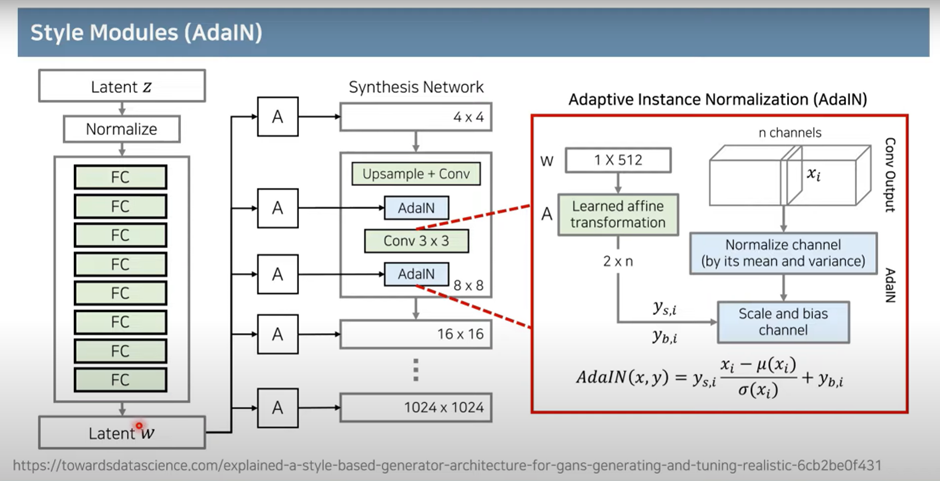

## PGGAN 아키텍쳐
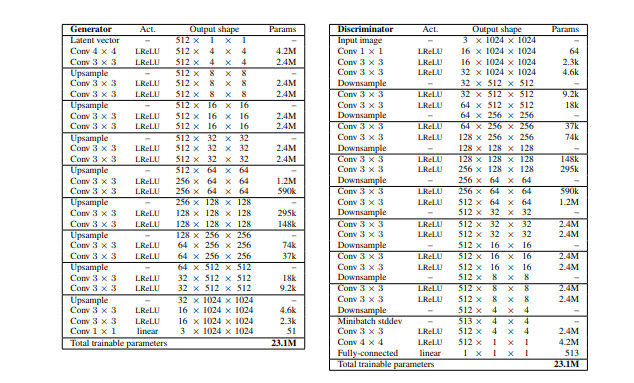

In [ ]:
# Constraints
# Input: [batch_size, in_channels, height, width]

# Scaled weight - He initialization
# "explicitly scale the weights at runtime"
class ScaleW:
    '''
    Constructor: name - name of attribute to be scaled
    '''
    def __init__(self, name):
        self.name = name
    
    def scale(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()
        
        return weight * math.sqrt(2 / fan_in) # He initialization?
    
    @staticmethod
    def apply(module, name):
        '''
        Apply runtime scaling to specific module
        '''
        hook = ScaleW(name)
        weight = getattr(module, name)
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        del module._parameters[name]
        module.register_forward_pre_hook(hook)
    
    def __call__(self, module, whatever):
        weight = self.scale(module)
        setattr(module, self.name, weight)

# Quick apply for scaled weight
def quick_scale(module, name='weight'):
    ScaleW.apply(module, name)
    return module

# Uniformly set the hyperparameters of Linears
# "We initialize all weights of the convolutional, fully-connected, and affine transform layers using N(0, 1)"
# 5/13: Apply scaled weights
class SLinear(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()

        linear = nn.Linear(dim_in, dim_out)
        linear.weight.data.normal_()
        linear.bias.data.zero_()
        
        self.linear = quick_scale(linear)

    def forward(self, x):
        return self.linear(x)

# Uniformly set the hyperparameters of Conv2d
# "We initialize all weights of the convolutional, fully-connected, and affine transform layers using N(0, 1)"
# 5/13: Apply scaled weights
class SConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        
        self.conv = quick_scale(conv)

    def forward(self, x):
        return self.conv(x)

# Normalization on every element of input vector
# latent vector -> normailzation 하는 부분인듯
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)

# "learned affine transform" A
# AdaIN layer에 들어가는 style 정보가 될 수 있도록 affine transform 실시
class FC_A(nn.Module):
    '''
    Learned affine transform A, this module is used to transform
    midiate vector w into a style vector
    '''
    def __init__(self, dim_latent, n_channel):
        super().__init__()
        self.transform = SLinear(dim_latent, n_channel * 2)
        # "the biases associated with ys that we initialize to one"
        self.transform.linear.bias.data[:n_channel] = 1
        self.transform.linear.bias.data[n_channel:] = 0

    def forward(self, w):
        # Gain scale factor and bias with:
        style = self.transform(w).unsqueeze(2).unsqueeze(3) # dim2와 3에 1인 차원을 추가 
        # unsqueeze -> 차원 추가 / squeeze -> 차원 제거
        return style
    
# AdaIn (AdaptiveInstanceNorm)
class AdaIn(nn.Module):
    '''
    adaptive instance normalization
    '''
    def __init__(self, n_channel):
        super().__init__()
        self.norm = nn.InstanceNorm2d(n_channel)
        
    def forward(self, image, style):
        factor, bias = style.chunk(2, 1) # style tensor를 1차원(channel 별로) 2개로 쪼갬.
        result = self.norm(image) # 먼저 각 채널별 normalization 
        result = result * factor + bias  # scale을 곱해주고 + bias를 더해줌
        return result

# "learned per-channel scaling factors" B
# 5/13: Debug - tensor -> nn.Parameter
class Scale_B(nn.Module):
    '''
    Learned per-channel scale factor, used to scale the noise
    '''
    def __init__(self, n_channel):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros((1, n_channel, 1, 1)))
    
    def forward(self, noise):
        result = noise * self.weight
        return result 

# Early convolutional block
# 5/13: Debug - tensor -> nn.Parameter
# 5/13: Remove noise generating module
# TODO: Remove upsample

# 맨 처음의 conv block
class Early_StyleConv_Block(nn.Module):
    '''
    This is the very first block of generator that get the constant value as input
    '''
    def __init__ (self, n_channel, dim_latent, dim_input):
        super().__init__()
        # Constant input
        self.constant = nn.Parameter(torch.randn(1, n_channel, dim_input, dim_input)) # 맨 처음에는 constant vector를 넣어줌.
        # Style generators (각 블럭마다 스타일 2개씩 들어감)
        self.style1   = FC_A(dim_latent, n_channel)  
        self.style2   = FC_A(dim_latent, n_channel)
        # Noise processing modules(Adain layer 전에 noise를 넣어줌)
        self.noise1   = quick_scale(Scale_B(n_channel))
        self.noise2   = quick_scale(Scale_B(n_channel))
        # AdaIn
        self.adain    = AdaIn(n_channel)
        self.lrelu    = nn.LeakyReLU(0.2)
        # Convolutional layer
        self.conv     = SConv2d(n_channel, n_channel, 3, padding=1) # 3 x 3 conv 진행
    
    def forward(self, latent_w, noise):
        # Gaussian Noise: Proxyed by generator
        # noise1 = torch.normal(mean=0,std=torch.ones(self.constant.shape)).cuda()
        # noise2 = torch.normal(mean=0,std=torch.ones(self.constant.shape)).cuda()
        result = self.constant.repeat(noise.shape[0], 1, 1, 1) # constant vector 넣어주고
        result = result + self.noise1(noise) # noise 넣어주고
        result = self.adain(result, self.style1(latent_w)) # Adain layer거치고
        result = self.lrelu(result)
        result = self.conv(result) # conv 3 x 3 들어가고
        result = result + self.noise2(noise)  # noise 넣어주고
        result = self.adain(result, self.style2(latent_w)) # 두번째 Adain Layer
        result = self.lrelu(result)
        
        return result
    
# General convolutional blocks
# 5/13: Remove upsampling
# 5/13: Remove noise generating
class StyleConv_Block(nn.Module):
    '''
    This is the general class of style-based convolutional blocks
    '''
    def __init__ (self, in_channel, out_channel, dim_latent):
        super().__init__()
        # Style generators
        self.style1   = FC_A(dim_latent, out_channel)
        self.style2   = FC_A(dim_latent, out_channel)
        # Noise processing modules
        self.noise1   = quick_scale(Scale_B(out_channel))
        self.noise2   = quick_scale(Scale_B(out_channel))
        # AdaIn
        self.adain    = AdaIn(out_channel)
        self.lrelu    = nn.LeakyReLU(0.2)
        # Convolutional layers
        self.conv1    = SConv2d(in_channel, out_channel, 3, padding=1)
        self.conv2    = SConv2d(out_channel, out_channel, 3, padding=1)
    
    def forward(self, previous_result, latent_w, noise):
        # Upsample: Proxyed by generator
        # result = nn.functional.interpolate(previous_result, scale_factor=2, mode='bilinear',
        #                                           align_corners=False)
        # Conv 3*3
        result = self.conv1(previous_result) # 첫번째 conv layer 통과
        # Gaussian Noise: Proxyed by generator
        # noise1 = torch.normal(mean=0,std=torch.ones(result.shape)).cuda()
        # noise2 = torch.normal(mean=0,std=torch.ones(result.shape)).cuda()
        # Conv & Norm
        result = result + self.noise1(noise) # noise 넣어주고
        result = self.adain(result, self.style1(latent_w)) # 첫번째 adain layer
        result = self.lrelu(result)
        result = self.conv2(result) # 두 번째 conv layer 통과
        result = result + self.noise2(noise) # noise 넣어주고
        result = self.adain(result, self.style2(latent_w)) # 두번째 adain layer
        result = self.lrelu(result)
        
        return result    

# Very First Convolutional Block
# 5/13: No more downsample, this block is the same sa general ones
# class Early_ConvBlock(nn.Module):
#     '''
#     Used to construct progressive discriminator
#     '''
#     def __init__(self, in_channel, out_channel, size_kernel, padding):
#         super().__init__()
#         self.conv = nn.Sequential(
#             SConv2d(in_channel, out_channel, size_kernel, padding=padding),
#             nn.LeakyReLU(0.2),
#             SConv2d(out_channel, out_channel, size_kernel, padding=padding),
#             nn.LeakyReLU(0.2)
#         )
    
#     def forward(self, image):
#         result = self.conv(image)
#         return result
    
# General Convolutional Block
# 5/13: Downsample is now removed from block module
class ConvBlock(nn.Module):
    '''
    Used to construct progressive discriminator
    '''
    def __init__(self, in_channel, out_channel, size_kernel1, padding1, 
                 size_kernel2 = None, padding2 = None):
        super().__init__()
        
        if size_kernel2 == None:
            size_kernel2 = size_kernel1
        if padding2 == None:
            padding2 = padding1
        
        self.conv = nn.Sequential(
            SConv2d(in_channel, out_channel, size_kernel1, padding=padding1),
            nn.LeakyReLU(0.2),
            SConv2d(out_channel, out_channel, size_kernel2, padding=padding2),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, image):
        # Downsample now proxyed by discriminator
        # result = nn.functional.interpolate(image, scale_factor=0.5, mode="bilinear", align_corners=False)
        # Conv
        result = self.conv(image)
        return result
        
    
# Main components
# mapping network
class Intermediate_Generator(nn.Module):
    '''
    A mapping consists of multiple fully connected layers.
    Used to map the input to an intermediate latent space W.
    '''
    def __init__(self, n_fc, dim_latent):
        super().__init__()
        layers = [PixelNorm()]
        for i in range(n_fc): # n개 만큼의 fc layer로 반복하여 들어감.
            layers.append(SLinear(dim_latent, dim_latent))
            layers.append(nn.LeakyReLU(0.2))
            
        self.mapping = nn.Sequential(*layers)
    
    def forward(self, latent_z):
        latent_w = self.mapping(latent_z)
        return latent_w    

# Generator
# 5/13: Support progressive training
# 5/13: Proxy noise generating
# 5/13: Proxy upsampling
# TODO: style mixing

class StyleBased_Generator(nn.Module):
    '''
    Main Module
    '''
    def __init__(self, n_fc, dim_latent, dim_input):
        super().__init__()
        # Waiting to adjust the size
        self.fcs    = Intermediate_Generator(n_fc, dim_latent)
        self.convs  = nn.ModuleList([
            Early_StyleConv_Block(512, dim_latent, dim_input),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 256, dim_latent),
            StyleConv_Block(256, 128, dim_latent),
            StyleConv_Block(128, 64, dim_latent),
            StyleConv_Block(64, 32, dim_latent),
            StyleConv_Block(32, 16, dim_latent)
        ])
        self.to_rgbs = nn.ModuleList([
            SConv2d(512, 3, 1),
            SConv2d(512, 3, 1),
            SConv2d(512, 3, 1),
            SConv2d(512, 3, 1),
            SConv2d(256, 3, 1),
            SConv2d(128, 3, 1),
            SConv2d(64, 3, 1),
            SConv2d(32, 3, 1),
            SConv2d(16, 3, 1)
        ])
    def forward(self, latent_z, 
                step = 0,  # Step means how many layers (count from 4 x 4) are used to train
                alpha=-1,  # Alpha is the parameter of smooth conversion of resolution):
                noise=None,     # TODO: support input noise
                mix_steps=[]):     # steps inside will use latent_z[1], else latent_z[0]
        if type(latent_z) != type([]):
            print('You should use list to package your latent_z')
            latent_z = [latent_z]
        if (len(latent_z) != 2 and len(mix_steps) > 0) or type(mix_steps) != type([]):
            print('Warning: Style mixing disabled, possible reasons:')
            print('- Invalid number of latent vectors')
            print('- Invalid parameter type: mix_steps')
            mix_steps = []
        
        latent_w = [self.fcs(latent) for latent in latent_z]
        batch_size = latent_w[0].size(0)
        
        # Generate needed Gaussian noise
        # 5/22: Noise is now generated by outer module
        # noise = []
        result = 0
        current_latent = 0
        # for i in range(step + 1):
        #     size = 4 * 2 ** i # Due to the upsampling, size of noise will grow
        #     noise.append(torch.randn((batch_size, 1, size, size), device=torch.device('cuda:0')))
        
        for i, conv in enumerate(self.convs):
            # Choose current latent_w
            if i in mix_steps:
                current_latent = latent_w[1]
            else:
                current_latent = latent_w[0]
                
            # Not the first layer, need to upsample
            if i > 0 and step > 0:
                result_upsample = nn.functional.interpolate(result, scale_factor=2, mode='bilinear',
                                                  align_corners=False) # Upsample 과정
                result = conv(result_upsample, current_latent, noise[i])
            else:
                result = conv(current_latent, noise[i])
            
            # Final layer, output rgb image
            if i == step:
                result = self.to_rgbs[i](result)
                
                if i > 0 and 0 <= alpha < 1:
                    result_prev = self.to_rgbs[i - 1](result_upsample)
                    result = alpha * result + (1 - alpha) * result_prev
                    
                # Finish and break
                break
        
        return result

# Discriminator
# 5/13: Support progressive training
# 5/13: Add downsample module
# Component of Progressive GAN
# Reference: Karras, T., Aila, T., Laine, S., & Lehtinen, J. (2017).
# Progressive Growing of GANs for Improved Quality, Stability, and Variation, 1–26.
# Retrieved from http://arxiv.org/abs/1710.10196
class Discriminator(nn.Module):
    '''
    Main Module
    '''
    def __init__(self):
        super().__init__()
        # Waiting to adjust the size
        self.from_rgbs = nn.ModuleList([
            SConv2d(3, 16, 1),
            SConv2d(3, 32, 1),
            SConv2d(3, 64, 1),
            SConv2d(3, 128, 1),
            SConv2d(3, 256, 1),
            SConv2d(3, 512, 1),
            SConv2d(3, 512, 1),
            SConv2d(3, 512, 1),
            SConv2d(3, 512, 1)
       ])
        self.convs  = nn.ModuleList([
            ConvBlock(16, 32, 3, 1),
            ConvBlock(32, 64, 3, 1),
            ConvBlock(64, 128, 3, 1),
            ConvBlock(128, 256, 3, 1),
            ConvBlock(256, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(513, 512, 3, 1, 4, 0)
        ])
        self.fc = SLinear(512, 1)
        
        self.n_layer = 9 # 9 layers network
    
    def forward(self, image, 
                step = 0,  # Step means how many layers (count from 4 x 4) are used to train
                alpha=-1):  # Alpha is the parameter of smooth conversion of resolution):
        for i in range(step, -1, -1):
            # Get the index of current layer
            # Count from the bottom layer (4 * 4)
            layer_index = self.n_layer - i - 1 
            
            # First layer, need to use from_rgb to convert to n_channel data
            if i == step: 
                result = self.from_rgbs[layer_index](image)
            
            # Before final layer, do minibatch stddev
            if i == 0:
                # In dim: [batch, channel(512), 4, 4]
                res_var = result.var(0, unbiased=False) + 1e-8 # Avoid zero
                # Out dim: [channel(512), 4, 4]
                res_std = torch.sqrt(res_var)
                # Out dim: [channel(512), 4, 4]
                mean_std = res_std.mean().expand(result.size(0), 1, 4, 4)
                # Out dim: [1] -> [batch, 1, 4, 4]
                result = torch.cat([result, mean_std], 1)
                # Out dim: [batch, 512 + 1, 4, 4]
            
            # Conv
            result = self.convs[layer_index](result)
            
            # Not the final layer
            if i > 0:
                # Downsample for further usage
                result = nn.functional.interpolate(result, scale_factor=0.5, mode='bilinear',
                                                  align_corners=False)
                # Alpha set, combine the result of different layers when input
                if i == step and 0 <= alpha < 1:
                    result_next = self.from_rgbs[layer_index + 1](image)
                    result_next = nn.functional.interpolate(result_next, scale_factor=0.5,
                                                           mode = 'bilinear', align_corners=False)
                
                    result = alpha * result + (1 - alpha) * result_next
                    
        # Now, result is [batch, channel(512), 1, 1]
        # Convert it into [batch, channel(512)], so the fully-connetced layer 
        # could process it.
        result = result.squeeze(2).squeeze(2)
        result = self.fc(result)
        return result

In [ ]:
# use idel gpu
# it's better to use enviroment variable
# if you want to use multiple gpus, please
# modify hyperparameters at the same time
# And Make Sure Your Pytorch Version >= 1.0.1
import os
os.environ['CUDA_VISIBLE_DEVICES']='1, 2'
n_gpu             = 2
device            = torch.device('cuda:0')

learning_rate     = {128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003}
batch_size_1gpu   = {4: 128, 8: 128, 16: 64, 32: 32, 64: 16, 128: 16}
mini_batch_size_1 = 8
batch_size        = {4: 256, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16}
mini_batch_size   = 8
batch_size_4gpus  = {4: 512, 8: 256, 16: 128, 32: 64, 64: 32}
mini_batch_size_4 = 16
batch_size_8gpus  = {4: 512, 8: 256, 16: 128, 32: 64}
mini_batch_size_8 = 32
n_fc              = 8
dim_latent        = 512
dim_input         = 4
n_sample          = 120000
DGR               = 1
n_show_loss       = 40
step              = 1 # Train from (8 * 8)
max_step          = 8 # Maximum step (8 for 1024^2)
style_mixing      = [] # Waiting to implement
image_folder_path = './dataset/'
save_folder_path  = './results/'

low_steps         = [0, 1, 2]
# style_mixing    += low_steps
mid_steps         = [3, 4, 5]
# style_mixing    += mid_steps
hig_steps         = [6, 7, 8]
# style_mixing    += hig_steps

# Used to continue training from last checkpoint
startpoint        = 0
used_sample       = 0
alpha             = 0

# Mode: Evaluate? Train?
is_train          = True

# How to start training?
# True for start from saved model
# False for retrain from the very beginning
is_continue       = True
d_losses          = [float('inf')]
g_losses          = [float('inf')]
inputs, outputs = [], []

def set_grad_flag(module, flag):
    for p in module.parameters():
        p.requires_grad = flag

def reset_LR(optimizer, lr):
    for pam_group in optimizer.param_groups:
        mul = pam_group.get('mul', 1)
        pam_group['lr'] = lr * mul
        
# Gain sample
def gain_sample(dataset, batch_size, image_size=4):
    transform = transforms.Compose([
            transforms.Resize(image_size),          # Resize to the same size
            transforms.CenterCrop(image_size),      # Crop to get square area
            transforms.RandomHorizontalFlip(),      # Increase number of samples
            transforms.ToTensor(),            
            transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))])

    dataset.transform = transform
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=8)

    return loader

def imshow(tensor, i):
    grid = tensor[0]
    grid.clamp_(-1, 1).add_(1).div_(2)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    img = Image.fromarray(ndarr)
    img.save(f'{save_folder_path}sample-iter{i}.png')
    plt.imshow(img)
    plt.show()
    
# Train function
def train(generator, discriminator, g_optim, d_optim, dataset, step, startpoint=0, used_sample=0,
         d_losses = [], g_losses = [], alpha=0):
    
    resolution  = 4 * 2 ** step
    
    origin_loader = gain_sample(dataset, batch_size.get(resolution, mini_batch_size), resolution)
    data_loader = iter(origin_loader)
    
    reset_LR(g_optim, learning_rate.get(resolution, 0.001))
    reset_LR(d_optim, learning_rate.get(resolution, 0.001))
    
    progress_bar = tqdm(range(startpoint + 1, n_sample * 5))
    # Train
    for i in progress_bar:
        alpha = min(1, alpha + batch_size.get(resolution, mini_batch_size) / (n_sample * 2))
        
        if used_sample > n_sample * 2 and step < max_step: 
            step += 1
            
            alpha = 0
            used_sample = 0
            
            resolution = 4 * 2 ** step
            
            # Avoid possble memory leak
            del origin_loader
            del data_loader
            
            # Change batch size
            origin_loader = gain_sample(dataset, batch_size.get(resolution, mini_batch_size), resolution)
            data_loader = iter(origin_loader)
            
#             torch.save({
#                 'generator'    : generator.module.state_dict(),
#                 'discriminator': discriminator.module.state_dict(),
#                 'g_optim'      : g_optim.state_dict(),
#                 'd_optim'      : d_optim.state_dict()
#             }, f'checkpoint/train.pth')
            
            reset_LR(g_optim, learning_rate.get(resolution, 0.001))
            reset_LR(d_optim, learning_rate.get(resolution, 0.001))
            
        
        try:
            # Try to read next image
            real_image, label = next(data_loader)

        except (OSError, StopIteration):
            # Dataset exhausted, train from the first image
            data_loader = iter(origin_loader)
            real_image, label = next(data_loader)
        
        # Count used sample
        used_sample += real_image.shape[0]
        
        # Send image to GPU
        real_image = real_image.to(device)
        
        # D Module ---
        # Train discriminator first
        discriminator.zero_grad()
        set_grad_flag(discriminator, True)
        set_grad_flag(generator, False)
        
        # Real image predict & backward
        # We only implement non-saturating loss with R1 regularization loss
        real_image.requires_grad = True
        if n_gpu > 1:
            real_predict = nn.parallel.data_parallel(discriminator, (real_image, step, alpha), range(n_gpu))
        else:
            real_predict = discriminator(real_image, step, alpha)
        real_predict = nn.functional.softplus(-real_predict).mean()
        real_predict.backward(retain_graph=True)

        grad_real = torch.autograd.grad(outputs=real_predict.sum(), inputs=real_image, create_graph=True)[0]
        grad_penalty_real = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
        grad_penalty_real = 10 / 2 * grad_penalty_real
        grad_penalty_real.backward()
        
        # Generate latent code
        latent_w1 = [torch.randn((batch_size.get(resolution, mini_batch_size), dim_latent), device=device)]
        latent_w2 = [torch.randn((batch_size.get(resolution, mini_batch_size), dim_latent), device=device)]

        noise_1 = []
        noise_2 = []
        for m in range(step + 1):
            size = 4 * 2 ** m # Due to the upsampling, size of noise will grow
            noise_1.append(torch.randn((batch_size.get(resolution, mini_batch_size), 1, size, size), device=device))
            noise_2.append(torch.randn((batch_size.get(resolution, mini_batch_size), 1, size, size), device=device))
        
        # Generate fake image & backward
        if n_gpu > 1:
            fake_image = nn.parallel.data_parallel(generator, (latent_w1, step, alpha, noise_1), range(n_gpu))
            fake_predict = nn.parallel.data_parallel(discriminator, (fake_image, step, alpha), range(n_gpu))
        else:
            fake_image = generator(latent_w1, step, alpha, noise_1)
            fake_predict = discriminator(fake_image, step, alpha)

        fake_predict = nn.functional.softplus(fake_predict).mean()
        fake_predict.backward()
        
        if i % n_show_loss == 0:
            d_losses.append((real_predict + fake_predict).item())
        
        # D optimizer step
        d_optim.step()
        
        # Avoid possible memory leak
        del grad_penalty_real, grad_real, fake_predict, real_predict, fake_image, real_image, latent_w1
                   
        # G module ---
        if i % DGR != 0: continue
        # Due to DGR, train generator
        generator.zero_grad()
        set_grad_flag(discriminator, False)
        set_grad_flag(generator, True)
        
        if n_gpu > 1:
            fake_image = nn.parallel.data_parallel(generator, (latent_w2, step, alpha, noise_2), range(n_gpu))
            fake_predict = nn.parallel.data_parallel(discriminator, (fake_image, step, alpha), range(n_gpu))
        else: 
            fake_image = generator(latent_w2, step, alpha, noise_2)
            fake_predict = discriminator(fake_image, step, alpha)
        fake_predict = nn.functional.softplus(-fake_predict).mean()
        fake_predict.backward()
        g_optim.step()

        if i % n_show_loss == 0:
            g_losses.append(fake_predict.item())
            imshow(fake_image.data.cpu(), i)
            
        # Avoid possible memory leak
        del fake_predict, fake_image, latent_w2
        
        if (i + 1) % 1000 == 0:
            # Save the model every 1000 iterations
            torch.save({
                'generator'    : generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'g_optim'      : g_optim.state_dict(),
                'd_optim'      : d_optim.state_dict(),
                'parameters'   : (step, i, used_sample, alpha),
                'd_losses'     : d_losses,
                'g_losses'     : g_losses
            }, 'checkpoint/trained.pth')
            print(f'Iteration {i} successfully saved.')
        
        progress_bar.set_description((f'Resolution: {resolution}*{resolution}  D_Loss: {d_losses[-1]:.4f}  G_Loss: {g_losses[-1]:.4f}  Alpha: {alpha:.4f}'))
        
    return d_losses, g_losses


# generator      = nn.DataParallel(StyleBased_Generator(n_fc, dim_latent, dim_input)).cuda()
# discriminator  = nn.DataParallel(Discriminator()).cuda()  
# g_optim        = optim.Adam([{
#     'params': generator.module.convs.parameters(),
#     'lr'    : 0.001
# }, {
#     'params': generator.module.to_rgbs.parameters(),
#     'lr'    : 0.001
# }], lr=0.001, betas=(0.0, 0.99))
# g_optim.add_param_group({
#     'params': generator.module.fcs.parameters(),
#     'lr'    : 0.001 * 0.01,
#     'mul'   : 0.01
# })

generator      = StyleBased_Generator(n_fc, dim_latent, dim_input).to(device)
discriminator  = Discriminator().to(device)
g_optim        = optim.Adam([{
    'params': generator.convs.parameters(),
    'lr'    : 0.001
}, {
    'params': generator.to_rgbs.parameters(),
    'lr'    : 0.001
}], lr=0.001, betas=(0.0, 0.99))
g_optim.add_param_group({
    'params': generator.fcs.parameters(),
    'lr'    : 0.001 * 0.01,
    'mul'   : 0.01
})
d_optim        = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.0, 0.99))
dataset        = datasets.ImageFolder(image_folder_path)

if is_continue:
    if os.path.exists('checkpoint/trained.pth'):
        # Load data from last checkpoint
        print('Loading pre-trained model...')
        checkpoint = torch.load('checkpoint/trained.pth')
        generator.load_state_dict(checkpoint['generator'])
        discriminator.load_state_dict(checkpoint['discriminator'])
        g_optim.load_state_dict(checkpoint['g_optim'])
        d_optim.load_state_dict(checkpoint['d_optim'])
        step, startpoint, used_sample, alpha = checkpoint['parameters']
        d_losses = checkpoint.get('d_losses', [float('inf')])
        g_losses = checkpoint.get('g_losses', [float('inf')])
    else:
        print('No pre-trained model detected, restart training...')
        
if is_train:
    generator.train()
    discriminator.train()    
    d_losses, g_losses = train(generator, discriminator, g_optim, d_optim, dataset, step, startpoint, used_sample, d_losses, g_losses, alpha)
else:
    # Do some evaluation here
    pass